# Workflow for processing Lake George - 24JUL18 - Landsat 8

In [1]:
import time
start_time = time.time()

import numpy as np

#
# Set up input and output directories
#
indir = '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/Lake_George/24JUL18/'
output = '/g/data/u46/users/aw3463/GuyByrne/calval/PNGS/LKG-24JUl18-L8/'

#
# field_data is in the format: 'Field Site Name', 'Date', 'Site number', 'Satellite Name', 'Panel origin', 'Reflectance/Radiance'.
# and 'Radiance'/'Reflectance'.
# NOTE: Satellite name should be one of: 'Landsat8', 'Sentinel2a', or 'Sentinel2b'.
#
field_data = ['LKG', '24JUL18', '', 'Landsat8', 'GA_Panel', 'Radiance']

#
# bad_pans    contains the names of individual panels readings that appear to be bogus
# bad_grounds contains ground-reading file names that appear to be bogus
# Use empty lists if there are no bad spectra.
#
bad_grounds = []
bad_pans = []

#
# Define the first line and spectrum number for all/good panels and grounds
#
firstGoodLine = 1
firstGoodPanelSpec = 0
firstGoodGroundSpec = 2

#
# Calculated BRDF data
#
brdf_data = np.array([['', 'brdf0', 'brdf1', 'brdf2'],
                          ['band1', 0.06750333333333333, 0.018913333333333334, 0.00803],
                          ['band11', 0.2657966666666667, 0.17357333333333333, 0.026243333333333334],
                          ['band12', 0.17504666666666668, 0.08564666666666668, 0.025760000000000005],
                          ['band2', 0.06750333333333333, 0.018913333333333334, 0.00803],
                          ['band3', 0.10392666666666667, 0.044206666666666665, 0.012636666666666666],
                          ['band4', 0.11351666666666668, 0.049640000000000004, 0.013080000000000001],
                          ['band5', 0.11351666666666668, 0.049640000000000004, 0.013080000000000001],
                          ['band6', 0.11351666666666668, 0.049640000000000004, 0.013080000000000001],
                          ['band7', 0.2331266666666667, 0.13984666666666667, 0.020703333333333334],
                          ['band8', 0.2331266666666667, 0.13984666666666667, 0.020703333333333334],
                          ['band8a', 0.2331266666666667, 0.13984666666666667, 0.020703333333333334],
                         ])

#
# plot_scale defines the extent of the axes in the final two plots in the workflow.
# A scale from 0-1 means no reflectance to perfect reflectance. Typically, dark sites
# will range from 0-0.3, whereas bright sites will be between 0-1.
#
plot_scale = [0.0, 1.0, 0.0, 1.0]

#
# Define corners of field data, if GPS coordinates are NOT written into headers.
# Order is SE, SW, NE, NW. Units are decimal degrees.
# If there are no coordinates, then set RockWalk to either True or False.
# True  means that the field site was walked in a rock-like pattern (alternating directions),
# False means that the field site was walked in a roll-like pattern (same direction)
#
Corners = [0, 0, 0, 0, 0, 0, 0, 0]
RockWalk = True
StartCorner = 'SE'

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import datacube
import sys, os, shutil
sys.path.append("..")

from CalVal import *

#
# Use notebook format (allows inline zooming and moving of figures)
# Set default font size for all plots
#
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams['savefig.dpi'] = 300

#
# Remove old files in directory and create a new one
#
directory = os.path.dirname(output)
if os.path.exists(directory):
    shutil.rmtree(directory)
os.makedirs(directory)

In [3]:
#######################################
# LINES BELOW SHOULD REMAIN UNCHANGED #
#######################################
#
# panel_dir and in_panel refer to the file that is used in determining the k-factor,
# so this should remain unchanged.
#
if field_data[5] == 'Radiance':
    suffix = 'asd.rad.txt'
else: 
    suffix = 'asd.txt'

panel_dir =  '/g/data1a/u46/users/aw3463/GuyByrne/30APR18/Panels/'

if field_data[4] == 'GA_Panel':
    in_panel = 'ga_panel1_jan_2018.txt'
elif field_data[4] == 'CSIRO_Panel':
    in_panel = 'csiro_panel.txt'
elif field_data[4] == 'UA_Panel':
    in_panel = 'ua_panel.txt'
elif field_data[4] == 'UOW_Panel':
    in_panel = 'uow_panel.txt'
elif field_data[4] == 'UQ_Panel':
    in_panel = 'uq_panel.txt'
elif field_data[4] == 'CSIRO_VIC_Panel':
    in_panel = 'csiro_vic_panel.txt'
else:
    nopanel = '***PANEL NAME NOT KNOWN***'
    print(nopanel)

#
# Setup for Landsat and Sentinel bandpass filters
#
sat_resp = dict({'Landsat5': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat5_vsir.flt', 
            'Landsat7': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat7_vsir.flt', 
            'Landsat8': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/landsat8_vsir.flt',
            'Sentinel2a': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2a.flt',
            'Sentinel2b': '/g/data1a/u46/users/aw3463/GuyByrne/misc_others/Sent2b.flt'})

f_name = sat_resp[field_data[3]]

#
# Colours used for plotting multi-coloured Lines
#
colpac=['#770000', '#FF0000', '#FF7700', '#FFFF00', '#77FF00', '#00FF00', 
        '#00FF77', '#00FFFF', '#0077FF', '#0000FF', '#000077', '#FF00FF', '#777777', '#770077', '#777700']

#
# Start Figure numbering at 1
#
fignum = 1

### Define 'alldata' as the dataframe that contains all the raw spectra.
Show the first wavelength of every spectrum, so that the data integrity can be checked.

In [4]:
alldata = LoadData.load_from_dir(indir, suffix, firstGoodLine, Corners)

alldata[alldata['Wavelength']==350]

,Wavelength,radiance,filename,date_saved,Latitude,Longitude,Line,Spec_number,Inst_number
0,350,0.071829,lkg_s2b_ln100000.asd.rad,2018-07-24 00:14:32,-35.092883,149.462273,1,0,18179/2
0,350,0.071773,lkg_s2b_ln100001.asd.rad,2018-07-24 00:14:36,-35.092885,149.462277,1,1,18179/2
0,350,0.003855,lkg_s2b_ln100002.asd.rad,2018-07-24 00:15:01,-35.092582,149.462323,1,2,18179/2
0,350,0.004020,lkg_s2b_ln100003.asd.rad,2018-07-24 00:15:04,-35.092583,149.462298,1,3,18179/2
0,350,0.003748,lkg_s2b_ln100004.asd.rad,2018-07-24 00:15:08,-35.092590,149.462257,1,4,18179/2
0,350,0.004124,lkg_s2b_ln100005.asd.rad,2018-07-24 00:15:12,-35.092595,149.462218,1,5,18179/2
0,350,0.003962,lkg_s2b_ln100006.asd.rad,2018-07-24 00:15:16,-35.092603,149.462180,1,6,18179/2
0,350,0.004193,lkg_s2b_ln100007.asd.rad,2018-07-24 00:15:19,-35.092605,149.462152,1,7,18179/2
0,350,0.004197,lkg_s2b_ln100008.asd.rad,2018-07-24 00:15:23,-35.092612,149.462112,1,8,18179/2
0,350,0.004615,lkg_s2b_ln100009.asd.rad,2018-07-24 00:15:27,-35.092612,149.462078,1,9,18179/2


### Print out time stamp and coordinate extent for BRDF correction

The time stamp and Lat/Long extents are required to calculate the BRDF correction, used below.

In order to calculate the BRF correction, the following method is used:

<OL>
    <LI>Run the print statements in the cell below.</LI>
    <LI>Copy and paste the output into a VDI terminal window</LI>
    <LI>Copy and paste the resultant VDI output into the BRDF calculation cell, writing over the similar text.</LI>
</OL>

NOTE: This works assuming that the BRDF code is in the current directory.


In [5]:
PrintBRDF.print_brdf(alldata, field_data)

#################################################################################
# Copy and paste the following into a terminal window on VDI for Landsat 8 data #
#################################################################################

source module.sh
sed -i "34s/.*/        setattr(self, 'acquisition_datetime', dateutil.parser.parse('2018-07-24 00:14:32'))/" retrieve_brdf.py
sed -i "37s/.*/        bbox = geopandas.GeoDataFrame({'geometry': [box(149.461155, -35.092885, 149.46246, -35.09161666666667)]})/" retrieve_brdf.py
python retrieve_brdf.py > temp.txt ; awk -f format_Sent.awk temp.txt



### Specify which spectra are panels/ground/good/bad

 Determine panel file names by assuming that all panels have a data value of at least 0.06
 in the first wavelength (350nm). Call this dataframe 'panel_names'.

 good_panels = all panel data with bad panels removed<BR>
 bad_panels  = all bad panel data<BR>
 all_panels = both good and bad panel data<BR>
 good_grounds = good ground readings<BR>
 all_grounds = all ground data.<P>
 Any bad ground data (bad_grounds) is defined in the 2nd cell.


In [6]:
panel_names, all_panels, good_panels, bad_panels, good_grounds, all_grounds = ExtractPanelsGrounds.extract_panels_grounds(alldata, bad_pans, bad_grounds, field_data)

### Create dataframes for all/good/bad panel spectra.

For the bad panel spectra dataframe, first check to see if bad panels have been defined.<BR>
If not, then don't create anything.

In [7]:
all_panel_spec = MakeSpecDF.make_spec_df(all_panels)
good_panel_spec = MakeSpecDF.make_spec_df(good_panels)
try:
    bad_panel_spec = MakeSpecDF.make_spec_df(bad_panels)
except UnboundLocalError:
    pass

# Figure 

### Plot panel radiances for all/good/bad panels

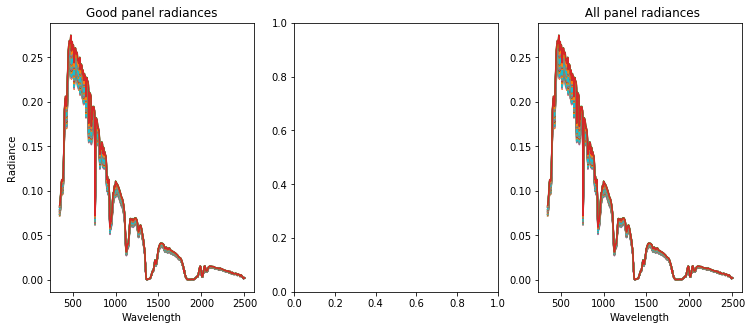

In [8]:
if field_data[5] == 'Radiance':
    try:
        FIG_PanelRadiances.FIG_panel_radiances(good_panel_spec, bad_panel_spec, all_panel_spec, output, field_data, fignum)
    except NameError:
        bad_panel_spec = [0,0]
        FIG_PanelRadiances.FIG_panel_radiances(good_panel_spec, bad_panel_spec, all_panel_spec, output, field_data, fignum)

fignum += 1

# Figure 

### Diagnosis plots of bad panel spectra

In [9]:
if field_data[5] == 'Radiance':
    good_panel_mean = good_panel_spec.mean(axis=1)

    try:
        FIG_BadPanelAnalysis.FIG_bad_panel_analysis(good_panel_mean, good_panel_spec, bad_panel_spec, output, field_data, fignum)
    except AttributeError:
        pass
fignum +=1

### Create spectral dataframes for all ground spectra and good ground spectra

In [10]:
all_grounds_spec = MakeSpecDF.make_spec_df(all_grounds)
good_grounds_spec = MakeSpecDF.make_spec_df(good_grounds)

# Figure 

### Plot ground spectra (all and good), normalised to the median good spectrum

These plots are used to identify any ground spectra that are bogus.

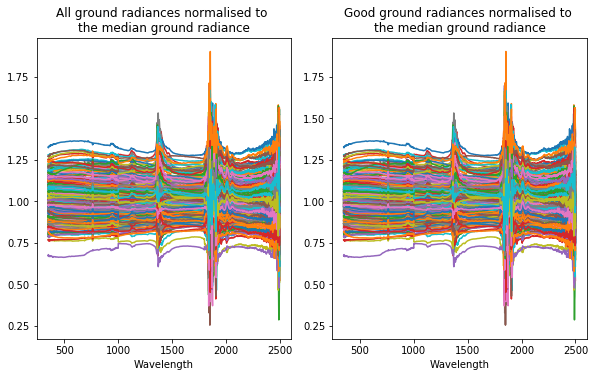

In [11]:
FIG_GroundSpectra.FIG_ground_spectra(good_grounds_spec, all_grounds_spec, output, field_data, fignum)
fignum +=1

### Create time-relative dataframes

gpt = good panels<BR>
gpta = all panels<BR>
adt = good grounds<BR>
adta = all grounds

In [12]:
gpt, gpta, adt, adta = CreateTimeRelativeDF.create_time_relative_dfs(good_panels, all_panels, good_grounds, all_grounds)

### Add Solar angle to dataframes

Based on the spectrum Latitude, Longitude and time stamp, calculate the angle of<BR>
the Sun, with respect to the zenith. Append this number to the "good_panels" and<BR>
"good_grounds" dataframes.

In [13]:
if field_data[5] == 'Radiance':
    good_panels, good_grounds = SolarAngle.solar_angle(good_panels, good_grounds)

../CalVal/SolarAngle.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  good_spectra.Solar_angle[good_spectra['date_saved'] == times.iloc[i]] = solzen.iloc[i]


# Figure 

### Plot timelines for ALL panel and ground data, with one line in one panel

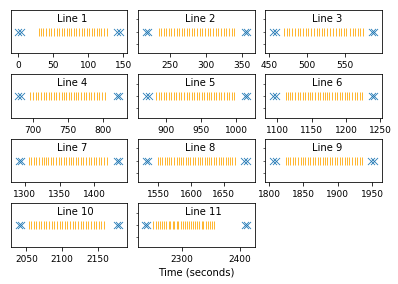

In [14]:
FIG_AllTimelines.FIG_all_timelines(gpta, adta, output, field_data, fignum)
fignum += 1

# Figure 

### Plot timelines for GOOD panel and ground data, with one line in one panel

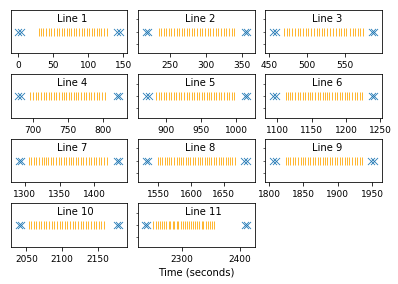

In [15]:
from CalVal.FIG_AllTimelines import panel_plot_layout, multi_timeline_plot

FIG_GoodTimelines.FIG_good_timelines(gpta, gpt, adt, panel_plot_layout, multi_timeline_plot, output, field_data, fignum)
fignum += 1

# Figure 

### Create timeline plot of averaged all/good panels

These plots are used to identify any panels that show unusually bright or dark readings,<BR>
    which can be weeded out as bad panels.
    
The general shape of the curve should follow "insolation" - the changing of incident light
due to the Sun rising/falling in the sky.

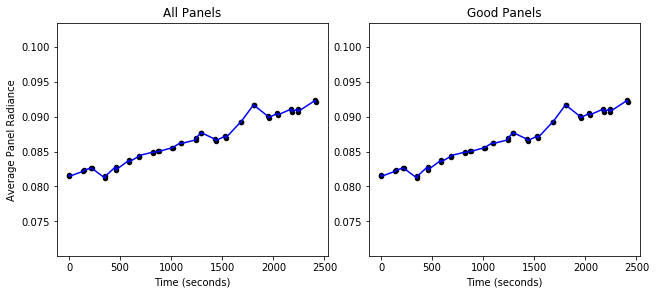

In [16]:
if field_data[5] == 'Radiance':
    gpt, gpta = FIG_NormalisedPanelsTimeline.normalise_spectra(good_panel_mean, good_panel_spec, all_panel_spec, gpt, gpta)

    FIG_NormalisedPanelsTimeline.FIG_normalised_panels_timeline(gpt, gpta, output, field_data, fignum)
fignum += 1

# Figure
### Fit Insolation Curve

Given that the total radiance (insolation, I) should increase with decreasing Solar zenith angle<BR>
(ie. as the Sun rises) and that I \propto cos(Solar zenith angle), we can fit the panel data to a<BR>
straight line. The ratio between the fit and the data points can then be used to adjust all panel
and ground spectra to account for insolation.<BR><BR>

Once the fit has been calculated, the following steps are taken (in subsequent cells):
<OL>
    <LI>The ratio between the fit and each averaged panel masurement is divided off the panels, so
        that they will all fall along the same line.
    <LI>For each Line (ie. walked Line in the field), the average panel spectrum is determined, as 
        well as the average panel Solar angle.
    <LI>The "Solar angle distance" for each ground spectrum to the averaged panel Solar angle is 
        used to divide off the insolation fit from the ground spectra. 

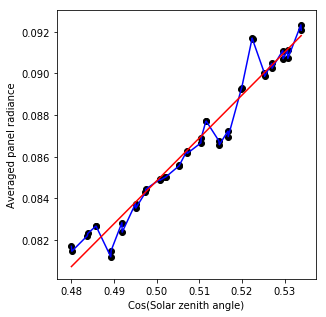

In [17]:
if field_data[5] == 'Radiance':
    slope, intercept, coszenith = FIG_InsolationFit.FIG_insolation_fit(gpt, output, field_data, fignum)
fignum += 1

### Scale good panels to insolation curve

Use the fitted insolation curve to determine individual offsets for each panel measurement and then divide<BR>
off the differences. This effectively removes any individual variations in the absolute scaling of panel<BR>
measurements.

In [18]:
if field_data[5] == 'Radiance':
    good_panels = ScalePanels.scale_panels(slope, intercept, coszenith, gpt, good_panels)

../CalVal/ScalePanels.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  good_panels.radiance[good_panels['date_saved'] == gpt['date_saved'].iloc[i]]/ratio.iloc[i]


### Scale ground spectra to insolation curve

For each line, calculate the mean panel spectrum and determine the fit at the according mean Solar zenith angle.<BR>
Then determine individual fits for all ground data within the line and apply the ratio of the panel mean fit to<BR>
ground fit to the good_grounds dataframe.

In [19]:
if field_data[5] == 'Radiance':
    good_grounds = ScaleGrounds.scale_grounds(good_panels, good_grounds, slope, intercept)

### Define the K-factor

This reads a standard file with a response curve for the detector, given an ideally white surface.<BR>
Then "k_f" is defined for the K-factor.

In [20]:
if field_data[5] == 'Radiance':
    k_f = KFactor.k_factor(panel_dir, in_panel)

### Re-Make Spectral Dataframes

After re-scaling of both good_panels and good_grounds, recreate the good_panel_spec and<BR>
good_grounds_spec dataframes

In [21]:
if field_data[5] == 'Radiance':
    good_panel_spec = MakeSpecDF.make_spec_df(good_panels)
    good_grounds_spec = MakeSpecDF.make_spec_df(good_grounds)

### Rename the first spectrum in ALL/GOOD panels to the correct name

Rather than just "radiance", it will be named something like radiance1-0<BR>
for the zeroth spectrum in the first line, for example.    

In [22]:
if field_data[5] == 'Radiance':
    SpecRename.spec_rename(good_panel_spec, good_grounds_spec, firstGoodLine, firstGoodPanelSpec, firstGoodGroundSpec)

### Create dataframe with Reflectances

In [23]:
if field_data[5] == 'Radiance':
    all_refls = CreateReflectances.create_reflectances(good_panels, good_panel_spec, good_grounds_spec, k_f)

### Test for reflectances
Test field_data to see if the data were saved as reflectances. If so, bypass all the panelling workflow.

In [24]:
if field_data[5] == 'Reflectance':
    all_refls = good_grounds_spec

# Figure 

### Plot all ground reflectances in black, plus the Line-averaged reflectances in colour

The Line-averaged reflectances are shown in order to identify any outlying lines that<BR>

might have been caused by bad panel spectra (for example).

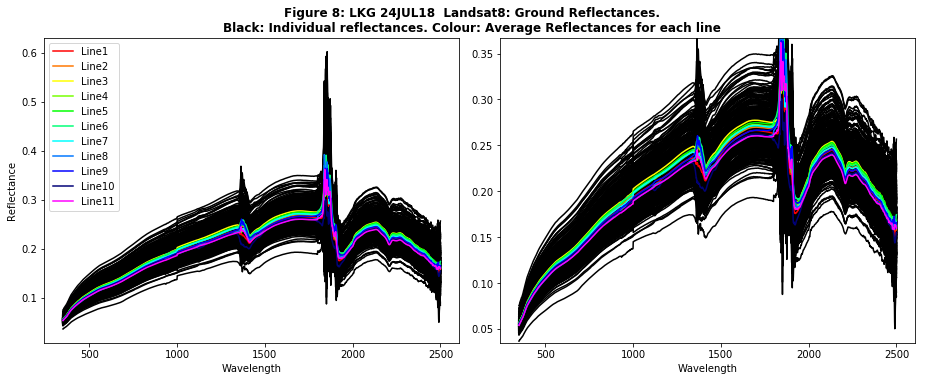

In [25]:
FIG_Reflectances.FIG_reflectances(good_panels, all_refls, colpac, output, field_data, fignum)
fignum += 1

### Apply weighted band responses to all reflectances

In [26]:
result_df, band = ApplyWeights.apply_weights(f_name, all_refls)

### Reformat band reflectances and apply to dataframe "ground_bands"

In [27]:
ground_bands = ReformatDF.reformat_df(good_grounds, result_df)

# Figure 

### Plot band reflectances

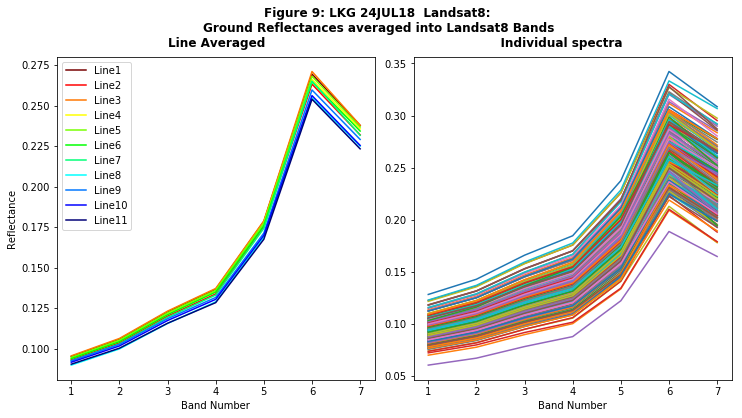

In [28]:
FIG_BandReflectances.FIG_band_reflectances(ground_bands, result_df, band, colpac, output, field_data, fignum)
fignum += 1

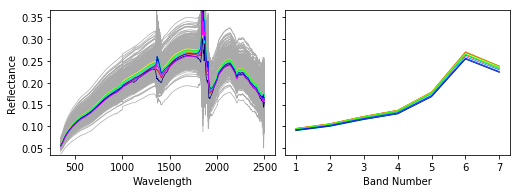

In [29]:
FIG_ReflectancesBand.FIG_reflectances_band(ground_bands, result_df, band, good_panels, all_refls, colpac, output, field_data, fignum)
fignum += 1

# Figure

### Histogram of all good spectra, plotted band-by-band

This can be used to identify outlying ground spectra that can be added to bad_grounds in the second cell.

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

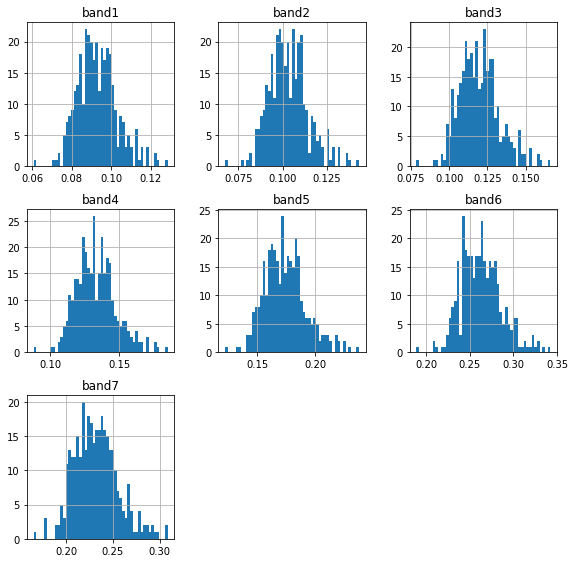

In [30]:
FIG_SpecHistogram.FIG_spec_histogram(ground_bands, output, field_data, fignum)
fignum += 1

### Outlying ground spectra

Display the spectra with maximum and minimum values. These can be compared to the histograms above<BR>
    to identify any outlying spectra that need to be identified as bad ground spectra.

In [31]:
maxfile = ground_bands['filename'][(ground_bands['band1'] == ground_bands['band1'].max())]
maxbands = ground_bands.filter(like='band')[(ground_bands['band1'] == ground_bands['band1'].max())]
minfile = ground_bands['filename'][(ground_bands['band1'] == ground_bands['band1'].min())]
minbands = ground_bands.filter(like='band')[(ground_bands['band1'] == ground_bands['band1'].min())]

print("Maximum value found in:", maxfile.iloc[0], '\n', maxbands.iloc[0], '\nMinimum value found in:', minfile.iloc[0], '\n', minbands.iloc[0])
#print(ground_bands['filename'][(ground_bands['band1'] == ground_bands['band1'].max())], '\n',ground_bands.filter(like='band')[(ground_bands['band1'] == ground_bands['band1'].max())])
#print(ground_bands['filename'][(ground_bands['band1'] == ground_bands['band1'].min())], '\n',ground_bands.filter(like='band')[(ground_bands['band1'] == ground_bands['band1'].min())])


Maximum value found in: lkg_s2b_ln400004.asd.rad 
 band1    0.128509
band2    0.143089
band3    0.166153
band4    0.184805
band5    0.237642
band6    0.342312
band7    0.308547
Name: 90, dtype: float64 
Minimum value found in: lkg_s2b_ln700004.asd.rad 
 band1    0.060755
band2    0.067440
band3    0.078558
band4    0.088083
band5    0.122463
band6    0.188886
band7    0.164928
Name: 184, dtype: float64


### Determine Solar angle

Based on the spectrum Latitude, Longitude and time stamp, calculate the angle of<BR>
the Sun, with respect to the zenith. Append this number to the "ground_bands" dataframe.

In [32]:
from CalVal.SolarAngle import solang
ground_bands['Solar_angle'] = ground_bands.apply(solang, axis=1)

### BRDF Calculation

The following script is adapted from FORTRAN code that will calculate the adjusted ASD measurement to 45$^\circ$. This is derived from "MODIS BRDF / Albedo Product: Algorithm Theoretical basis Docuement Version 5.0" by Strahler et al. (1999).

What follows is a key to the variables used in this code, compared to the variables and equations in the document:

hb and br = h/b and b/r . . . . . . . . . . . . . . . crown shape parameters, respectively.<BR>
RL_brdf = R($\theta, \vartheta, \phi, \Lambda$). . . . . . . . . . . . . . (37)<BR>
solar = $\theta$ . . . . . . . . . . . . . . . . . . . . . . . . . . solar zenith angle<BR>
view = $\xi$ . . . . . . . . . . . . . . . . . . . . . . . . . . .view zenith angle<BR>
ra = $\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . view-sun relative azimuth angle<BR>
cosxi = cos $\xi^\prime$ . . . . . . . . . . . . . . . . . . . . . . (43)<BR>
rs_thick = K$_{vol}$ = RossThick kernel . . . . . . (38)<BR>
d_li2 = D$^2$ . . . . . . . . . . . . . . . . . . . . . . . . . (42)<BR>
x_li = tan$\theta^\prime$ tan$\vartheta^\prime$ sin$\phi$ . . . . . . . . . . . . . . .(41) (part of)<BR>
cosl = cos $t$ . . . . . . . . . . . . . . . . . . . . . . . . (41)<BR>
l_li = $t$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . .constrained such that $-1 \leq t \leq 1$<BR>
o_li = O($\theta, \vartheta, \phi$) . . . . . . . . . . . . . . . . . . . .(40)<BR>
li_sparse = K$_{geo}$ . . . . . . . . . . . . . . . . . . . . (39)<BR><BR><BR>

Equations used for the Ross-Li BRDF model:

R($\theta, \vartheta, \phi, \Lambda$) = $f_{iso}(\Lambda) + f_{vol}(\Lambda)\,K_{vol}(\theta, \vartheta, \phi) + f_{geo}(\Lambda)\,K_{geo}(\theta, \vartheta, \phi)$ . . . . . . . . (37)

$K_{vol} = k_{RT} = \frac{(\pi/2 - \xi)\rm{cos}\,\xi + \rm{sin}\,\xi}{\rm{cos}\,\theta + \rm{cos}\,\vartheta} - \frac{\pi}{4}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (38)
    
$K_{geo} = k_{LSR} = O(\theta, \vartheta, \phi) - {\rm sec}\,\theta^\prime - {\rm sec}\,\vartheta^\prime + \frac{1}{2} (1 + \rm{cos}\,\xi^\prime)\, \rm{sec}\,\theta^\prime \rm{sec}\,\vartheta^\prime$ . . . (39)

$O = \frac{1}{\pi}(t - \rm{sin}\,t\,\,\rm{cos}\,t)(\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (40)

$\rm{cos}\,t = \frac{h}{b}\frac{\sqrt{D^2 + (\rm{tan}\,\theta^\prime\,\,\rm{tan}\,\vartheta^\prime\,\,\rm{sin}\,\phi)^2}}{\rm{sec}\,\theta^\prime + \rm{sec}\,\vartheta^\prime}$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . (41)

$D = \sqrt{\rm{tan}^2\,\theta^\prime + \rm{tan}^2\,\vartheta^\prime - 2\,\rm{tan}\,\theta^\prime\,\rm{tan}\,\vartheta^\prime\,\rm{cos}\,\phi}$ . . . . . . . . . . . . . . . . . . . . . . . . . . (42)

$\rm{cos}\,\xi^\prime = \rm{cos}\,\theta^\prime\,\rm{cos}\,\vartheta^\prime + \rm{sin}\,\theta^\prime\,\rm{sin}\,\vartheta^\prime\,\rm{cos}\,\phi$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(43)

$\theta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\theta)\,\vartheta^\prime = \rm{tan}^{-1}(\frac{b}{r}\rm{tan}\,\vartheta)$ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .(44)

In [33]:
ground_brdf, hb, br = BRDF.ReadAndCalc(brdf_data, ground_bands, field_data)

### Choose bands for Landsat 8 and Sentinel satellite data

In [34]:
from CalVal.ApplyWeights import get_spectrum_curve

band_nn = get_spectrum_curve(f_name)
senti_bands = [1,2,3,4,5,6,7,8,'8a',11,12]
ls8_bands = [1,2,3,4,5,6,7]

if field_data[3] == 'Landsat8':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in ls8_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in ls8_bands]

elif field_data[3] == 'Sentinel2a' or field_data[3] == 'Sentinel2b':
    band_min = [band_nn['band'+str(i)][:, 0].min() for i in senti_bands]
    band_max = [band_nn['band'+str(i)][:, 0].max() for i in senti_bands]

else:
    print('Satellite name should be one of Landsat8 or Sentinel. I got', field_data[3])

# Figure 

### Plot satellite band extents against median ground spectrum

This plot will show where the satellite bands fall, with respect to the spectrum<BR>
and in particular, with respect to the atmospheric absorbtion features.

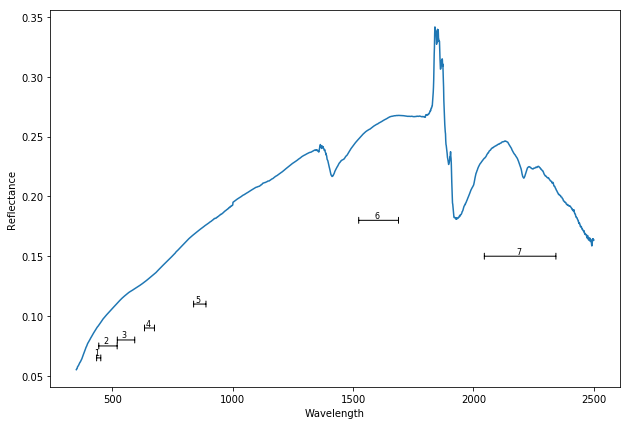

In [35]:
FIG_BandExtents.FIG_band_extents(all_refls, band_min, band_max, output, field_data, fignum)
fignum += 1

### Fudge GPS locations if none exist

In [36]:
ground_brdf = FudgeGPS.fudge_gps(ground_brdf, Corners, RockWalk, StartCorner)

Assuming good GPS Coordinates, continuing...


### Query Satellite data

Retrieve xarrays for satellite data, based on which satellite, query area and time.<BR>
sat_array will contain all band data<BR>
sat_bigarray will be a larger version of sat_array, which can be used for context plotting.<BR>
ls8_usgs_array will contain the USGS Level 2 product of Landsat 8 data.<BR>
ls8_usgs_bigarray will be the larger version of ls8_usgs_array.

In [37]:
dc, udc, query, query2 = Query.make_query(ground_brdf, field_data)

if field_data[3] == 'Landsat8':
    sat_array, sat_bigarray, ls8_usgs_array, ls8_usgs_bigarray = CreateSatArrays.create_sat_arrays(dc, udc, query, query2, field_data)    
else:
    sat_array, sat_bigarray = CreateSatArrays.create_sat_arrays(dc, udc, query, query2, field_data)

# Figure 

### Plot relative locations of field and satellite data

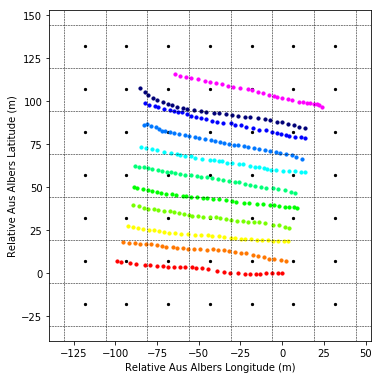

In [38]:
xloc = FIG_SatFieldLocations.FIG_sat_field_locations(ground_brdf, sat_array, colpac, output, field_data, fignum)
fignum +=1

### Create Field full band xarray

The field xarray is based on the pixel locations of the satellite data, where each pixel<BR>
    contains an average of all field data measurements that fall within the pixel.

In [39]:
field_array = CreateFieldFromSat.create_field_from_sat(sat_array, ground_brdf, xloc, field_data)

# Figure 

### Plot large-area context RGB array for Satellite data

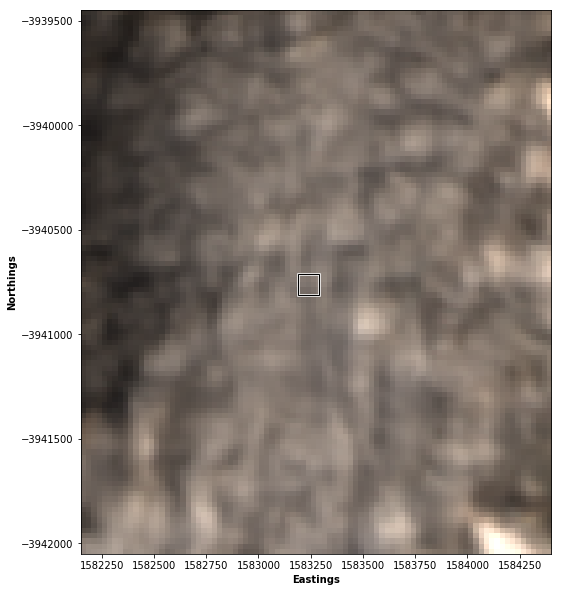

In [40]:
FIG_SatBigRGB.FIG_sat_bigRGB(sat_array, sat_bigarray, output, field_data, fignum)
fignum += 1

# Figure 

### Plot RGB array for Satellite data

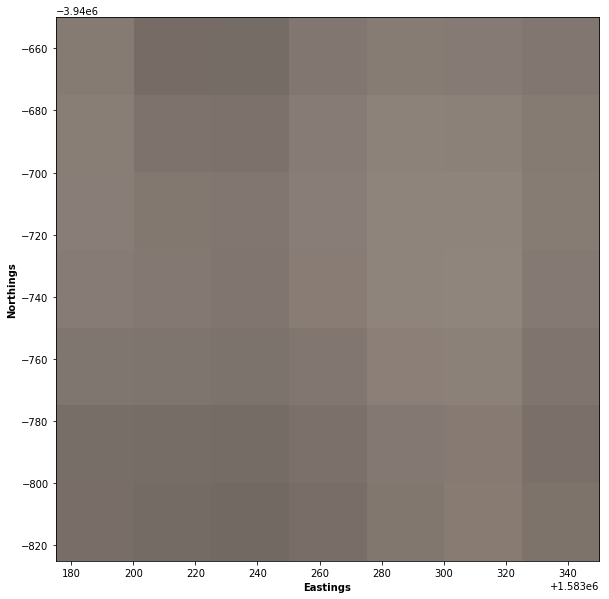

In [41]:
FIG_SatRGB.FIG_sat_RGB(sat_array, output, field_data, fignum)
fignum += 1

# Figure 

### Plot RGB array for Field data

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


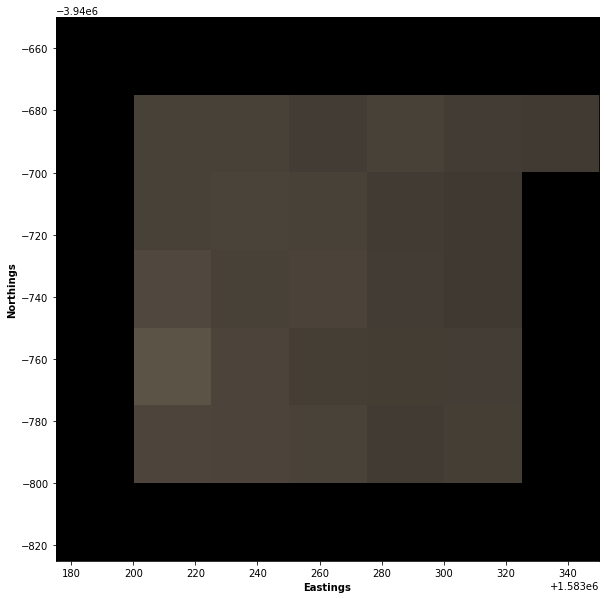

In [42]:
FIG_FieldRGB.FIG_field_RGB(field_array, output, field_data, fignum)
fignum += 1

## Figure
### Variance of satellite data

Band-by-band plots of the ratio of satellite data, divided by the mean, for each band are shown.
The title also lists the min, max and mean variance. Variance is defined as the ratio of the standard
deviation divided by the mean, for each band. The mean variance should typically be less than 5%.

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/_collections_abc.py:761: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for key in self._mapping:


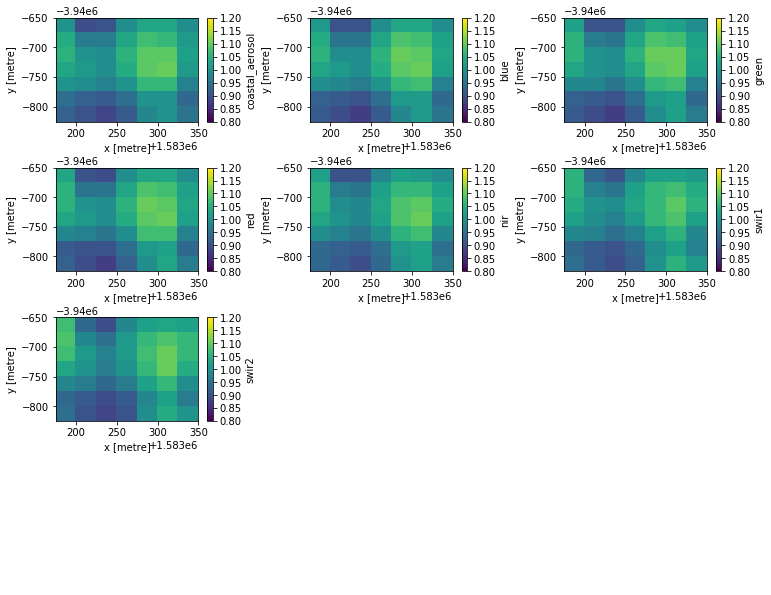

In [43]:
variance = FIG_SatBands.FIG_sat_bands(sat_array, field_array, output, field_data, fignum)
fignum += 1

# Figure

### Plot ratio arrays for each band

Each panel shows the ratio of satellite/field data.

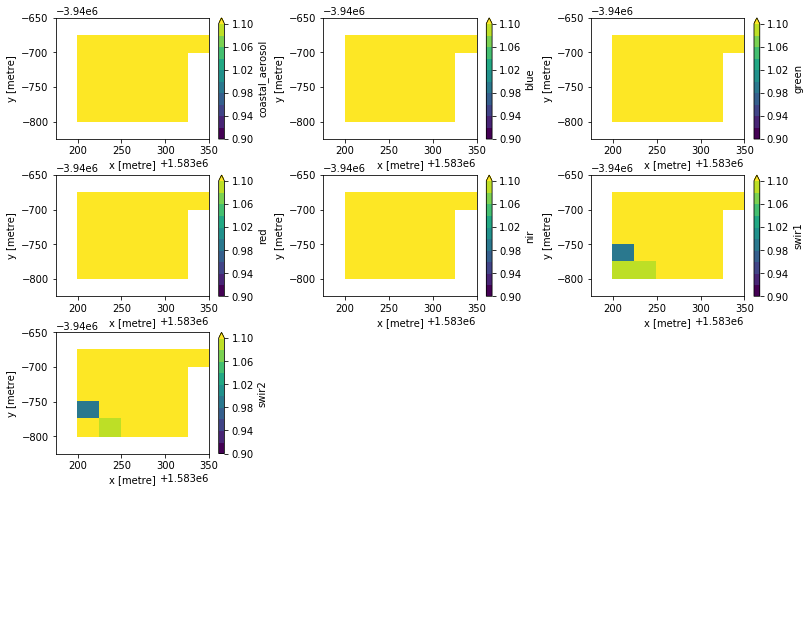

In [44]:
FIG_RatioArrays.FIG_ratio_arrays(sat_array, field_array, output, field_data, fignum)
fignum += 1

### Create a statistics dataframe, comparing satellite and field data

In [45]:
fstat_df = CreateStats.create_stats(sat_array, ground_brdf, field_data)

In [46]:
if field_data[3] == 'Landsat8':
    fstat_usgs_df = CreateStats.create_stats(ls8_usgs_array, ground_bands, field_data)

## Create a statistics dataframe, comparing satellite and field data,
for only those satellite pixels which overlap with at least one field data position.

In [47]:
finner_df = CreateSubStats.create_SUB_stats(sat_array, field_array, ground_brdf, fstat_df, field_data)

# Figure

### Plot comparison spectra of satellite and field data, on a pixel-by-pixel basis

Error bars are shown for the satellite and field data, based on the standard deviation of the pixels
within the field. The black line shows the satellite data, which has been averaged over all pixels that satisfy the Datacube query ie. all pixels shown in Figure 11. The orange line shows satellite data which has been averaged over only those pixels that overlap with at least one field measurement.

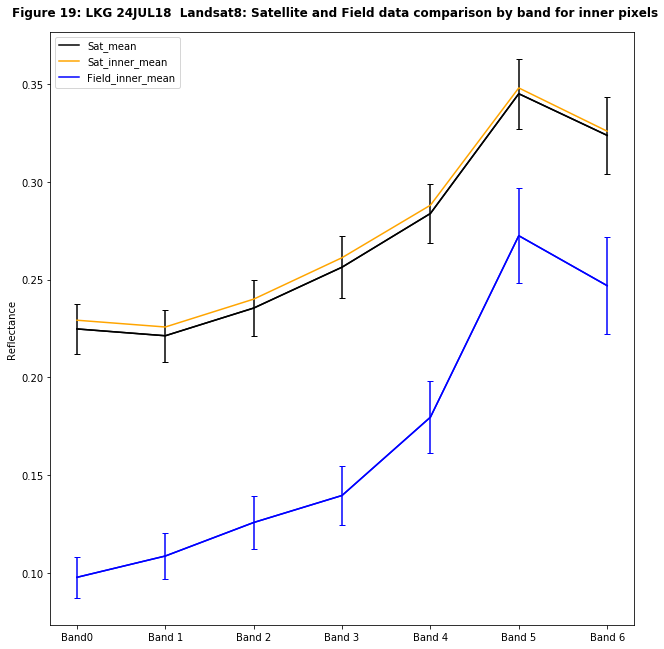

In [48]:
FIG_SubSatFieldBands.FIG_SUB_sat_field_bands(sat_array, fstat_df, finner_df, output, field_data, fignum)
fignum += 1

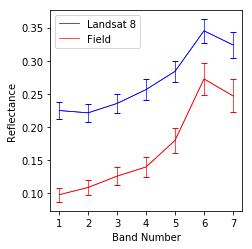

In [49]:
FIG_SatFieldBands.FIG_sat_field_bands(sat_array, fstat_df, finner_df, output, field_data, fignum)
fignum += 1

# Figure

### Comparison plot of Field and satellite data

Plot shows a pixel-by-pixel comparison of all pixels where field data exists.<BR> 
Different band data are shown in different colours and different symbols.

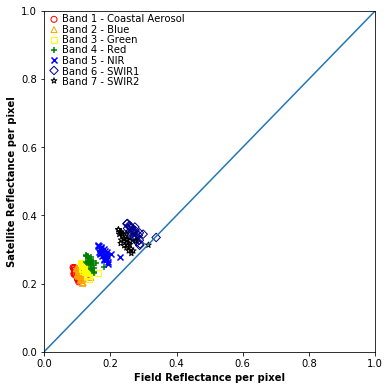

In [50]:
FIG_SatFieldScatterCompare.FIG_sat_field_scatter_compare(sat_array, field_array, plot_scale, output, field_data, fignum)
fignum += 1

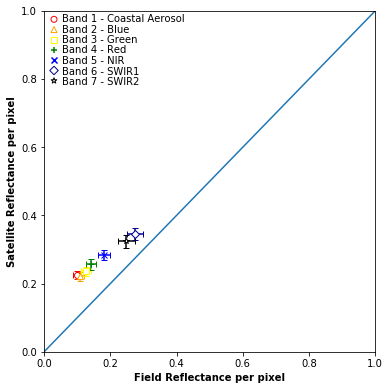

In [51]:
FIG_SatFieldAvgScatterCompare.FIG_sat_field_avg_scatter_compare(sat_array, field_array, plot_scale, fstat_df, output, field_data, fignum)
fignum += 1

## Print out summary data sheet

In [52]:
PrintSheet.print_sheet(ground_brdf, sat_array, fstat_df, indir, output, field_data, Corners, RockWalk, StartCorner, variance, query, dc)

In [53]:
fstat_df.to_csv('../CSV/'+field_data[0]+'_'+field_data[1]+'_'+field_data[2]+'_'+field_data[3]+'.csv')
if field_data[3] == 'Landsat8':
    fstat_usgs_df.to_csv('../CSV/'+field_data[0]+'_'+field_data[1]+'_'+field_data[2]+'_'+field_data[3]+'_USGS.csv')

In [54]:
if field_data[3] == 'Landsat8':
    import pandas as pd
    print('Difference in time between field site measurement and USGS LS8 data is '
          +str(pd.to_datetime(str(ls8_usgs_array.time.values[0])) - ground_brdf['date_saved'].min()))

Difference in time between field site measurement and USGS LS8 data is -3 days +23:34:29.670043


## How long did this notebook take to run?

In [55]:
import datetime
print("This Notebook took ", str(datetime.timedelta(seconds=int((time.time() - start_time)))), "(h:m:s) to run")

This Notebook took  0:03:40 (h:m:s) to run
